<a href="https://colab.research.google.com/github/AnDDoanf/OCR-repos/blob/master/OCR-CNN-RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [2]:
# !kaggle datasets download -d ssarkar445/handwriting-recognitionocr
# !unzip *.zip -d handwritten-dataset
# !rm *.zip

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

In [4]:
# Image Size
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Batch Size and Epoch (set higher for more accuracy)
BATCH_SIZE = 2
EPOCHS = 20

# Model Name
MODEL_NAME = 'Handwritten-OCR'

# Callbacks
CALLBACKS = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".h5", save_best_only=True)
]

# Learning Rate
LEARNING_RATE = 1e-3

# Random Seed
np.random.seed(42)
tf.random.set_seed(42)

# File Paths
train_csv_path = '/content/drive/MyDrive/Kaggle/handwritten-dataset/CSV/written_name_train.csv'
valid_csv_path = '/content/drive/MyDrive/Kaggle/handwritten-dataset/CSV/written_name_validation.csv'
test_csv_path = '/content/drive/MyDrive/Kaggle/handwritten-dataset/CSV/written_name_test.csv'

train_image_dir = '/content/drive/MyDrive/Kaggle/handwritten-dataset/train_v2/train'
valid_image_dir = '/content/drive/MyDrive/Kaggle/handwritten-dataset/validation_v2/validation'
test_image_dir = '/content/drive/MyDrive/Kaggle/handwritten-dataset/test_v2/test'

# Data Size
TRAIN_SIZE = BATCH_SIZE * 1000
VALID_SIZE = BATCH_SIZE * 500
TEST_SIZE  = BATCH_SIZE * 100

# AUTOTUNE
AUTOTUNE = tfd.AUTOTUNE

In [5]:
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]

train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [6]:
train_labels = [str(word) for word in train_csv['IDENTITY'].to_numpy()]
train_labels[:5]

['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE']

In [7]:
unique_chars = set(char for word in train_labels for char in word)
n_classes = len(unique_chars)

print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 31
Unique Characters : 
{'S', 'J', 'O', 'I', 'V', 'D', 'T', 'K', 'C', 'n', 'Z', "'", 'R', 'B', 'a', 'X', 'H', 'Q', 'U', 'G', 'M', 'N', 'F', 'A', 'P', 'E', '-', 'W', ' ', 'L', 'Y'}


In [8]:
MAX_LABEL_LENGTH = max(map(len, train_labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 19


In [9]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [10]:
# Character to numeric value dictionary
char_to_num = layers.StringLookup(
    vocabulary = list(unique_chars),
    mask_token = None
)

# Reverse dictionary
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

In [11]:
def load_image(image_path : str):
    image = tf.io.read_file(image_path)
    decoded_image = tf.image.decode_jpeg(contents = image, channels = 1)
    cnvt_image = tf.image.convert_image_dtype(image = decoded_image, dtype = tf.float32)
    resized_image = tf.image.resize(images = cnvt_image, size = (IMG_HEIGHT, IMG_WIDTH))
    image = tf.transpose(resized_image, perm = [1, 0, 2])
    image = tf.cast(image, dtype = tf.float32)
    return image

In [12]:
def encode_single_sample(image_path : str, label : str):
    image = load_image(image_path)
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    vecs = char_to_num(chars)
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)
    return {'image':image, 'label':vecs}

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [14]:
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 2000
Validation Data Size : 1000
Testing Data Size    : 200


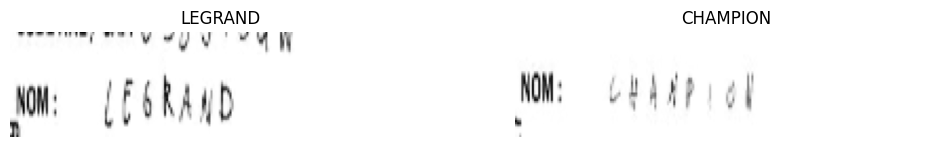

In [16]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    data = next(iter(data))
    images, labels = data['image'], data['label']
    for index, (image, label) in enumerate(zip(images, labels)):
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')

        if model is not None and decode_pred is not None:
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            plt.title(text_label)
    cls()
    plt.show()

show_images(data=train_ds, cmap='gray')

In [17]:
class CTCLayer(layers.Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        loss = self.loss_fn(y_true, y_pred, input_len, label_len)
        self.add_loss(loss)
        return y_pred

In [18]:
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")
target_labels = layers.Input(shape=(None, ), name="label")

x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*64))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.2)(encoding)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

ctc_layer = CTCLayer()(target_labels, output)

ocr_model = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

ocr_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 100, 25, 32)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 100, 25, 64)          18496     ['max_pooling2d[0][0]']   

In [ ]:
# tf.keras.utils.plot_model(ocr_model)

In [19]:
ocr_model.compile(optimizer='adam')

history = ocr_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=CALLBACKS
)

Epoch 1/20
1000/1000 [==============================] - 428s 401ms/step - loss: 21.3442 - val_loss: 20.6897
Epoch 2/20
   1/1000 [..............................] - ETA: 33s - loss: 16.3483

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - 31s 31ms/step - loss: 20.1980 - val_loss: 20.4063
Epoch 3/20
1000/1000 [==============================] - 28s 28ms/step - loss: 19.9314 - val_loss: 20.1934
Epoch 4/20
1000/1000 [==============================] - 28s 28ms/step - loss: 19.7846 - val_loss: 19.8021
Epoch 5/20
1000/1000 [==============================] - 27s 27ms/step - loss: 19.2766 - val_loss: 19.4153
Epoch 6/20
1000/1000 [==============================] - 26s 26ms/step - loss: 19.0305 - val_loss: 19.3636
Epoch 7/20
1000/1000 [==============================] - 28s 28ms/step - loss: 18.8885 - val_loss: 19.1982
Epoch 8/20
1000/1000 [==============================] - 27s 27ms/step - loss: 18.7732 - val_loss: 19.1872
Epoch 9/20
1000/1000 [==============================] - 25s 25ms/step - loss: 18.7176 - val_loss: 19.1178
Epoch 10/20
1000/1000 [==============================] - 26s 26ms/step - loss: 18.6442 - val_loss: 19.0820
Epoch 11/20
1000/1000 [==============================] -

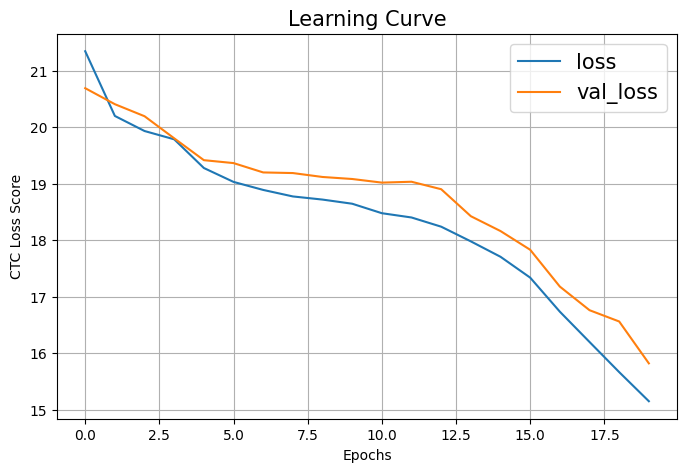

In [20]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()
plt.savefig("OCRModel-LearningCurve.png")
plt.show()

In [23]:
# Model required for inference
inference_model = keras.Model(
    inputs=ocr_model.get_layer(name="image").input,
    outputs=ocr_model.get_layer(name='dense_1').output
)

In [24]:
def decode_pred(pred_label):
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]
    chars = num_to_char(decode)
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts

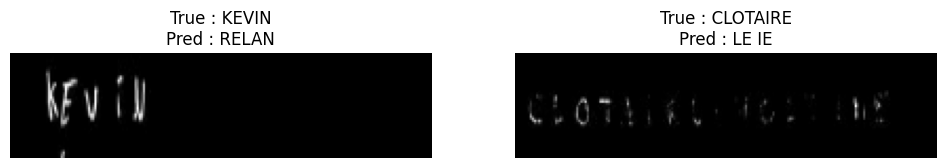

In [26]:
show_images(data=test_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')

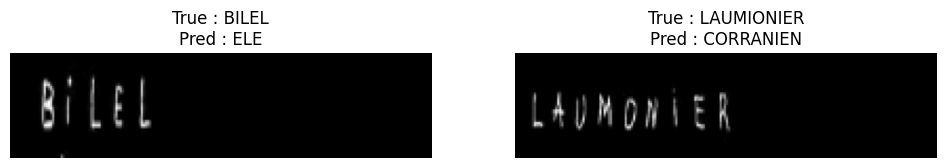

In [27]:
show_images(data=valid_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')